# Исследование надёжности заёмщиков

* Заказчик — кредитный отдел банка.
* Вопрос: влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок.
* Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Общая информация

### Загрузка данных

In [1]:
import pandas as pd  # импорт библиотеки pandas
import seaborn as sns  # импорт библиотеки seaborn
from pymystem3 import Mystem
from collections import Counter

data = pd.read_csv('/datasets/data.csv')  # чтение файла с данными и сохранение в data
data.head(10)  # получение первых 10 строк таблицы data для знакомства с данными

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [2]:
data.info()  # получение общей информации о данных в таблице df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [3]:
data.columns # получение информации о названиях колонок в таблице df

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

### Промежуточные выводы

1. В таблице двенадцать столбцов.
2. Типы данных: `object`, `int64` и `float64`.
3. Названия колонок выполнены строчными буквами в змеином регистре без пробелов. С учетом документации в целом понятно, что в них должно храниться, хотя есть вопросы.
4. Согласно описанию данных:
* `children` — количество детей в семье
 + целочисленный тип данных
 + пропусков нет
 + первые и последние 10 значений выглядят достоверными
 + ожидаемые значения от 0 до 5
 + столбец **имеет прямое** отношение к поставленным вопросам
---
* `days_employed` — общий трудовой стаж в днях
 + вещественный тип данных
 + встречаются как положительные, так и отрицательные значения (что странно). Положительные пока попались только у пенсионеров и имеют слишком большое значение для дней (340266.072047 / 365 ~ 932 года).
 + есть пропуски (возможно, человек не работал ни дня, но тогда бы был скорее 0)
 + столбец **не имеет прямого** отношения к поставленным вопросам
---
* `dob_years` — возраст клиента в годах
 + целочисленный тип данных
 + пропусков нет
 + ожидаемые значения от 18 до ~70 лет
 + столбец **не имеет прямого** отношения к поставленным вопросам
---
* `education` — уровень образования клиента
 + строковые значения, что корректно
 + пропусков нет
 + есть неявные дубликаты
 + столбец **не имеет прямого** отношения к поставленным вопросам
---
* `education_id` — идентификатор уровня образования
 + целочисленный тип данных
 + пропусков нет
 + столбец **не имеет прямого** отношения к поставленным вопросам
---
* `family_status` — семейное положение
 + строковые значения
 + пропусков нет
 + столбец **не имеет прямого** отношения к поставленным вопросам
---
* `family_status_id` — идентификатор семейного положения
 + целочисленный тип данных
 + пропусков нет
 + столбец **имеет прямое** отношение к поставленным вопросам
---
* `gender` — пол клиента
 + строковые значения
 + пропусков нет
 + столбец **не имеет прямого** отношения к поставленным вопросам
---
* `income_type` — тип занятости
 + строковый тип данных
 + пропусков нет
 + столбец **не имеет прямого** отношения к поставленным вопросам
---
* `debt` — имел ли задолженность по возврату кредитов
 + целочисленный тип данных
 + пропусков нет
 + предположительно должно встречаться два значения 0 и 1
 + столбец **имеет прямое** отношение к поставленным вопросам
---
* `total_income` — ежемесячный доход
 + вещественный тип данных
 + есть пропуски
 + не понятен порядок дохода
 + столбец **имеет прямое** отношение к поставленным вопросам
---
* `purpose` — цель получения кредита
 + строковый тип данных
 + пропусков нет
 + столбец **имеет прямое** отношение к поставленным вопросам

### Анализ каждого столбца по отдельности

Есть некоторые столбцы, которые не имеют прямого отношения к поставленным задачам, однако проведём краткий анализ каждого столбца. Данные могут понадобиться для работы со значимыми столбцами.

#### `children`

In [4]:
data['children'].value_counts().to_frame()  # подсчёт количества уникальных записей

,children
0,14149
1,4818
2,2055
3,330
20,76
-1,47
4,41
5,9


В столбце `children` присутствуют подозрительные (ошибочные?) значения `-1` и `20`

In [5]:
#  вывод data, в которых значение столбца children равно -1 или 20
data[(data['children'] == -1) | (data['children'] == 20)]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
291,-1,-4417.703588,46,среднее,1,гражданский брак,1,F,сотрудник,0,102816.346412,профильное образование
606,20,-880.221113,21,среднее,1,женат / замужем,0,M,компаньон,0,145334.865002,покупка жилья
705,-1,-902.084528,50,среднее,1,женат / замужем,0,F,госслужащий,0,137882.899271,приобретение автомобиля
720,20,-855.595512,44,среднее,1,женат / замужем,0,F,компаньон,0,112998.738649,покупка недвижимости
742,-1,-3174.456205,57,среднее,1,женат / замужем,0,F,сотрудник,0,64268.044444,дополнительное образование
...,...,...,...,...,...,...,...,...,...,...,...,...
21140,-1,-1422.668059,44,среднее,1,женат / замужем,0,F,компаньон,0,169562.091999,операции со своей недвижимостью
21325,20,-601.174883,37,среднее,1,женат / замужем,0,F,компаньон,0,102986.065978,профильное образование
21390,20,NaN,53,среднее,1,женат / замужем,0,M,компаньон,0,NaN,покупка жилой недвижимости
21404,20,-494.788448,52,среднее,1,женат / замужем,0,M,компаньон,0,156629.683642,операции со своей недвижимостью


* Данные значения выглядят как случайные ошибки.
* Восстановить данные по другим столбцам не представляется возможным.
* Ввиду их небольшого количества (123 из 21525 строк или 0,57%), в рамках ответа на вопрос о зависимости между наличием детей и возвратом кредита в срок данные строки достаточно просто исключить из выборки

#### `days_employed`

Данные по трудовому стажу клиентов выглядят непонятно, ещё и есть пропуски. Для понимания лучше визуализировать информацию. Трудовой стаж связан обычно с возрастом. Попробуем визуализировать эту зависимость с помощью seaborn.

In [1]:
# изменение размера графика до читаемого формата
sns.set(rc={'figure.figsize':(20, 10)})
# вывод графика: по оси X - данные из столбца days_employed,
# а по оси Y - данные из столбца dob_years
sns.scatterplot(x=data['days_employed'], y=data['dob_years'])
plot.show()

NameError: name 'sns' is not defined

Данные в столбце разделились на две явные группы: отрицательные значения, которые можно воспринимать как отработанные дни, и положительные значения, где измерение явно идёт не в днях. Предположим, что в часах. При этом 8-часовой или 12-часовой трудовой день не подходит, так как стаж всё равно получается слишком большим. Следовательно, можно предположить, что значения из второй группы необходимо поделить на 24.

In [7]:
# для дальнейшей работы внесём правки в days_employed
data.loc[data['days_employed'] > 300_000, 'days_employed'] /= 24
data.loc[data['days_employed'] < 0, 'days_employed'] *= -1

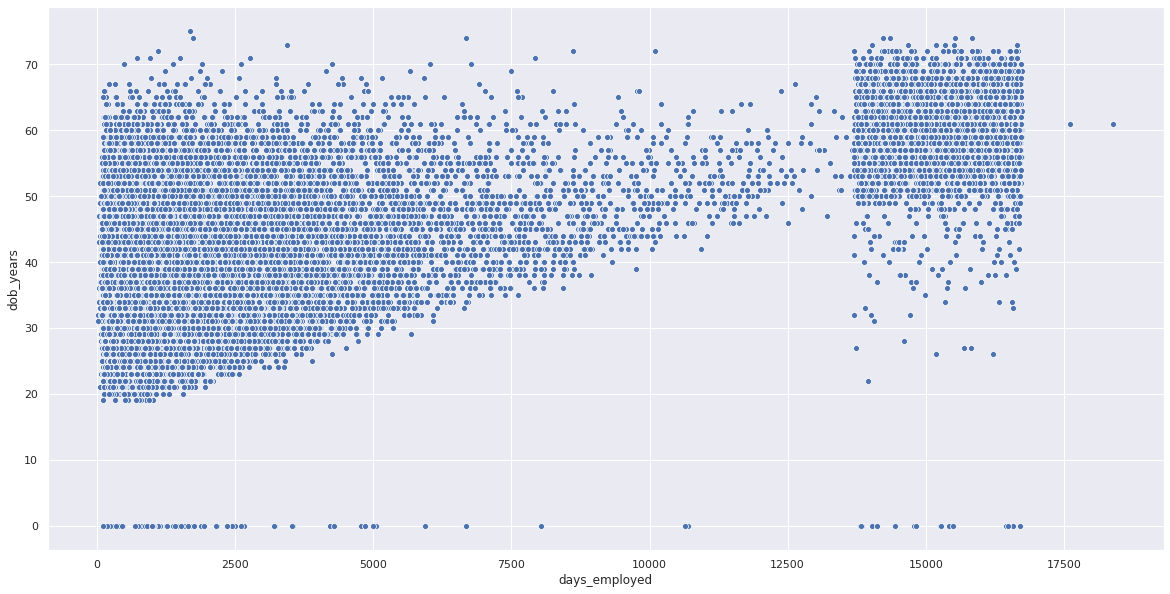

In [8]:
# вывод графика: по оси X - данные из столбца days_employed,
# а по оси Y - данные из столбца dob_years
sns.scatterplot(x=data['days_employed'], y=data['dob_years'])

In [9]:
# так как в столбце имеются пропущенные значения, то выведем их для анализа
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Предположительно пропущены значения как в столбце `days_employed`, так и `total_income`

In [10]:
data[data['days_employed'].isna() & data['total_income'].isna()].shape

(2174, 12)

Число пропущенных значений в каждом столбце: 21525 - 19351 = 2174, следовательно они пропущены в одних и тех же строках

#### `dob_years`

Стоит проверить как выглядит распределение по возрастам в целом.

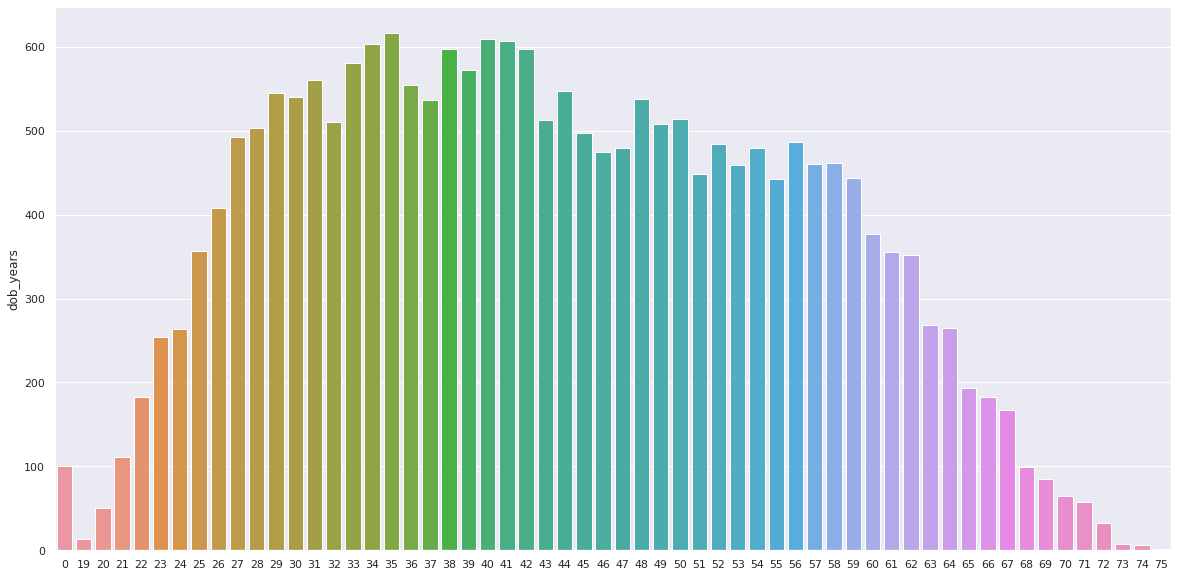

In [11]:
# вывод графика где по оси X - возраст клиентов,
# а по оси Y - количество записей, соответствующих каждому возрасту
sns.barplot(x=data['dob_years'].value_counts().index, y=data['dob_years'].value_counts())  

Распределение по возрастам выглядит нормальным за исключением, за исключением возраста равного 0.

In [12]:
# вывод количества записей в столбце dob_years равных 0
print('Число записей с возрастом равным нулю:', data[data['dob_years'] == 0]['dob_years'].count())

Число записей с возрастом равным нулю: 101


In [13]:
#  вывод первых 10 строк data, в которых значение столбца dob_years равно 0
data[data['dob_years'] == 0].head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
99,0,14439.234121,0,Среднее,1,женат / замужем,0,F,пенсионер,0,71291.522491,автомобиль
149,0,2664.273168,0,среднее,1,в разводе,3,F,сотрудник,0,70176.435951,операции с жильем
270,3,1872.663186,0,среднее,1,женат / замужем,0,F,сотрудник,0,102166.458894,ремонт жилью
578,0,16577.356876,0,среднее,1,женат / замужем,0,F,пенсионер,0,97620.687042,строительство собственной недвижимости
1040,0,1158.029561,0,высшее,0,в разводе,3,F,компаньон,0,303994.134987,свой автомобиль
1149,0,934.654854,0,среднее,1,женат / замужем,0,F,компаньон,0,201852.430096,покупка недвижимости
1175,0,15453.312833,0,среднее,1,женат / замужем,0,F,пенсионер,0,313949.845188,получение дополнительного образования
1386,0,5043.219890,0,высшее,0,женат / замужем,0,M,госслужащий,0,240523.618071,сделка с автомобилем
1890,0,NaN,0,высшее,0,Не женат / не замужем,4,F,сотрудник,0,NaN,жилье
1898,0,15422.689043,0,среднее,1,вдовец / вдова,2,F,пенсионер,0,127400.268338,на покупку автомобиля


Наличие в ряде записей возраста клиента равного нулю выглядит как случайные ошибки. Таких записей немного (101 из 21525 строк или 0,47%).

#### `education`

In [14]:
# подсчёт количества уникальных записей по столбцу education
data['education'].value_counts().to_frame()

,education
среднее,13750
высшее,4718
СРЕДНЕЕ,772
Среднее,711
неоконченное высшее,668
ВЫСШЕЕ,274
Высшее,268
начальное,250
Неоконченное высшее,47
НЕОКОНЧЕННОЕ ВЫСШЕЕ,29


В столбце `education` присутствуют неявные дубликаты, однако каких-либо ошибочных значений нет.

In [15]:
data['education'] = data['education'].str.lower()  # Приведем столбец education к нижнему регистру
data['education'].value_counts().to_frame()  # Проверка результата

,education
среднее,15233
высшее,5260
неоконченное высшее,744
начальное,282
ученая степень,6


#### `education_id`

In [16]:
# подсчёт количества уникальных записей по столбцу education_id
data['education_id'].value_counts().to_frame()

,education_id
1,15233
0,5260
2,744
3,282
4,6


По результатам анализа столбцов `education_id` и `education` можно сделать предположение, что между ними имеется следующее соответствие:
* 0 - клиент с высшим образованием
* 1 - клиент со средним образованием
* 2 - клиент с неоконченным высшим образованием
* 3 - клиент с начальным образованием
* 4 - клиент с учёной степенью

#### `family_status`

In [17]:
# подсчёт количества уникальных записей по столбцу family_status
data['family_status'].value_counts().to_frame()

,family_status
женат / замужем,12380
гражданский брак,4177
Не женат / не замужем,2813
в разводе,1195
вдовец / вдова,960


В столбце `family_status` каких-либо ошибочных значений нет. Для однообразия можно заменить "Не женат / не замужем" на "не женат / не замужем"

In [18]:
data.loc[data['family_status']=='Не женат / не замужем', 'family_status'] = 'не женат / не замужем'
data['family_status'].value_counts().to_frame()

,family_status
женат / замужем,12380
гражданский брак,4177
не женат / не замужем,2813
в разводе,1195
вдовец / вдова,960


#### `family_status_id`

In [19]:
# подсчёт количества уникальных записей по столбцу family_status_id
data['family_status_id'].value_counts().to_frame()

,family_status_id
0,12380
1,4177
4,2813
3,1195
2,960


По результатам анализа столбцов `family_status_id` и `family_status` и можно сделать предположение, что между ними имеется следующее соответствие:

* 0 - клиент женат/замужем
* 1 - клиент состоит в гражданском браке
* 2 - клиент вдовец/вдова
* 3 - клиент в разводе
* 4 - клиент не женат/не замужем

In [20]:
data.drop(['family_status', 'education'], axis=1, inplace=True)

#### `gender`

In [21]:
# подсчёт количества уникальных записей по столбцу gender
data['gender'].value_counts().to_frame()

,gender
F,14236
M,7288
XNA,1


Внезапно есть третий пол XNA или одно пропущенное значение.

#### `income_type`

In [22]:
# подсчёт количества уникальных записей по столбцу income_type
data['income_type'].value_counts().to_frame()

,income_type
сотрудник,11119
компаньон,5085
пенсионер,3856
госслужащий,1459
безработный,2
предприниматель,2
студент,1
в декрете,1


Какие-то неожиданности и аномалии отсутствуют.

#### `debt`

In [23]:
# подсчёт количества уникальных записей по столбцу debt
data['debt'].value_counts().to_frame()

,debt
0,19784
1,1741


Какие-то неожиданности и аномалии отсутствуют. Кажется, большинство клиентов возвращают долги вовремя.

#### total_income

В данном столбце также всречаются пропуски. Визуализируем его значения для анализа возможности их дальнейшего заполнения.

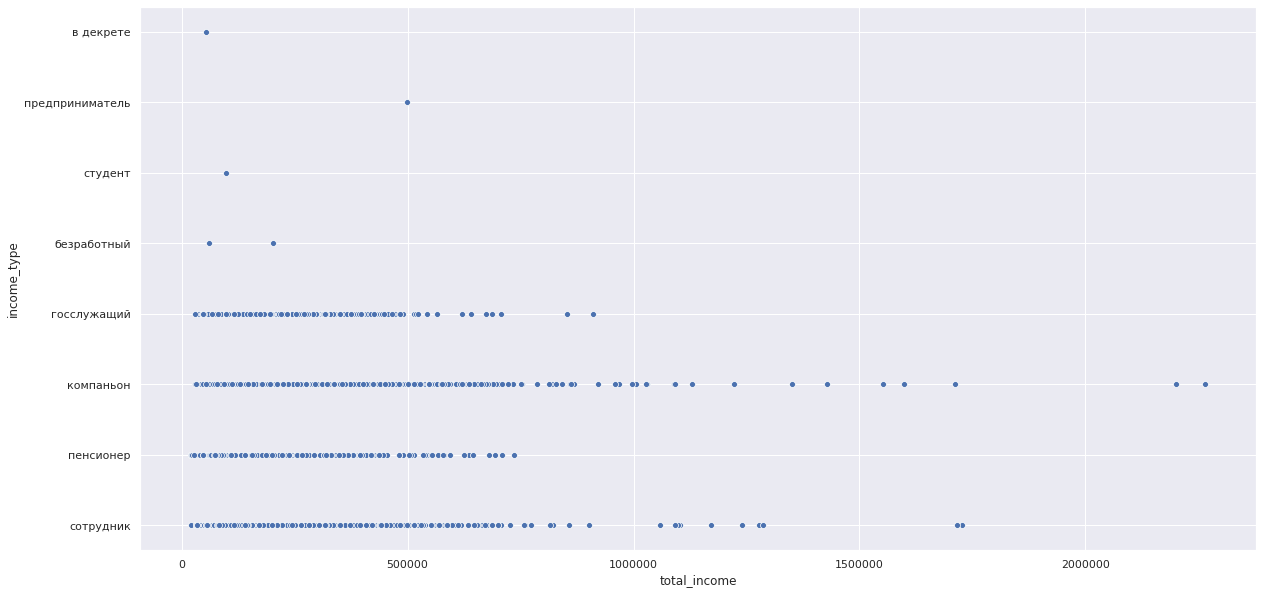

In [24]:
# вывод графика: по оси X - данные из столбца total_income,
# а по оси Y - данные из столбца income_type
sns.scatterplot(x=data['total_income'], y=data['income_type'])

Кроме пропущенных значений каких-либо аномалий в данном столбце нет.

#### `purpose`

In [25]:
# подсчёт количества уникальных записей по столбцу purpose
data['purpose'].value_counts().to_frame()  

,purpose
свадьба,797
на проведение свадьбы,777
сыграть свадьбу,774
операции с недвижимостью,676
покупка коммерческой недвижимости,664
операции с жильем,653
покупка жилья для сдачи,653
операции с коммерческой недвижимостью,651
покупка жилья,647
жилье,647


Какие-то неожиданности и аномалии отсутствуют. Есть опечатки, неявные дубликаты. Некоторые записи несут больше информации, чем другие.

### Выводы по данным

1. Информация по столбцам
* `children` — количество детей в семье
 + есть 0,5% недостоверных значений, которые необходимо исключить из выборки при анализе
---
* `days_employed` — общий трудовой стаж в днях
 + есть пропуски, надо заполнить. Корреляции с восрастом клиента нет.
 + необходимо поменять тип данных на целочисленный
---
* `dob_years` — возраст клиента в годах
 + есть 0,5% недостоверных значений, но столбец **не имеет прямого** отношения к поставленным вопросам. Для исследования **не нужен**.
---
* `education` — уровень образования клиента
 + столбец **не имеет прямого** отношения к поставленным вопросам. Для исследования **не нужен**.
---
* `education_id` — идентификатор уровня образования
 + столбец **не имеет прямого** отношения к поставленным вопросам. Для исследования **не нужен**.
---
* `family_status` — семейное положение
 + столбец **не имеет прямого** отношения к поставленным вопросам
---
* `family_status_id` — идентификатор семейного положения
 + столбец **имеет прямое** отношение к поставленным вопросам
---
* `gender` — пол клиента
 + столбец **не имеет прямого** отношения к поставленным вопросам. Для исследования **не нужен**.
---
* `income_type` — тип занятости
 + столбец **не имеет прямого** отношения к поставленным вопросам. Можно использовать для восстановления данных по столбцу `total_income`
---
* `debt` — имел ли задолженность по возврату кредитов
 + отсутствуют замечания по данным. 
---
* `total_income` — ежемесячный доход
 + есть пропуски
 + столбец **имеет прямое** отношение к поставленным вопросам
---
* `purpose` — цель получения кредита
 + столбец **имеет прямое** отношение к поставленным вопросам
 + цели указаны бессистемно, необходим ручной поиск дубликатов.

## Предобработка данных

### Обработка пропусков

In [26]:
data.isna().sum()  # подсчёт пропусков

children               0
days_employed       2174
dob_years              0
education_id           0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [27]:
# вывод строк с пропущенными значениями
display(data[data['days_employed'].isna()].head(10))

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,1,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,1,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,1,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,1,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,1,1,F,пенсионер,1,NaN,сыграть свадьбу
65,0,NaN,21,1,4,M,компаньон,0,NaN,операции с коммерческой недвижимостью
67,0,NaN,52,0,0,F,пенсионер,0,NaN,покупка жилья для семьи
72,1,NaN,32,0,0,M,госслужащий,0,NaN,операции с коммерческой недвижимостью
82,2,NaN,50,0,0,F,сотрудник,0,NaN,жилье
83,0,NaN,52,1,0,M,сотрудник,0,NaN,жилье


**Причины пропусков**

Каких-то закономерностей не наблюдается, предоположим, что пропуски случайны. Пропущенные данные относятся к количественным переменным. Возможно данные были утеряны в процессе обработки в автоматизированных системах или от клиента не было информации о доходах и трудовом стаже, что странно при выдаче кредита.

#### `days_employed`

In [28]:
print('Средний стаж равен:', int(data['days_employed'].mean()))
print('Медианное значение стажа равно:', int(data['days_employed'].median()))

Средний стаж равен: 4641
Медианное значение стажа равно: 2194


Хорошо бы знать как соотнести трудовой стаж в годах и трудовой стаж в днях, но нам это не известно. Для дальнейшего исследования выберим для заполнения пропусков медианное значение.

In [29]:
#  заполняем пропуски медианным значением
data.loc[data['days_employed'].isna(), 'days_employed'] = data['days_employed'].median()

In [30]:
data.info() # проверяем результат

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 10 columns):
children            21525 non-null int64
days_employed       21525 non-null float64
dob_years           21525 non-null int64
education_id        21525 non-null int64
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(3)
memory usage: 1.6+ MB


#### `total_income`

In [31]:
# заполним пропуски по доходу медианным значением с группировкой в зависимости от типа занятости
for income_type in data['income_type'].unique():  # перебираем виды занятости
    median = data.loc[data['income_type'] == income_type, 'total_income'].median() 
    data.loc[(data['total_income'].isna()) & (data['income_type'] == income_type), 'total_income'] = median

In [32]:
data.info()  # проверяем результат

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 10 columns):
children            21525 non-null int64
days_employed       21525 non-null float64
dob_years           21525 non-null int64
education_id        21525 non-null int64
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(3)
memory usage: 1.6+ MB


**Вывод об методах замены пропусков**

Пропуски в таблице устранены путем замены на медианное значение с помощью loc. При этом при выборе медианного значения для заполнения пропусков в данных о доходах учитывалось медианное значение в зависимости от типа занятости.

### Замена типа данных

Выполним замену типа данных для столбца `days_employed`

In [33]:
data['days_employed'] = data['days_employed'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 10 columns):
children            21525 non-null int64
days_employed       21525 non-null int64
dob_years           21525 non-null int64
education_id        21525 non-null int64
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null float64
purpose             21525 non-null object
dtypes: float64(1), int64(6), object(3)
memory usage: 1.6+ MB


**Вывод**

Замена данных в столбце `days_employed` с вещественного на целочисленный прошла успешно. Для замены типов, так как ошибок не было, использовался метод `astype`.


Заменять аналогичным образом данные в столбце `total_income` нецелесообразно, так как речь идёт о денежных суммах и вещественный тип данных здесь является уместным.

In [34]:
data['total_income'] = data['total_income'].astype(int)

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 10 columns):
children            21525 non-null int64
days_employed       21525 non-null int64
dob_years           21525 non-null int64
education_id        21525 non-null int64
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null int64
purpose             21525 non-null object
dtypes: int64(7), object(3)
memory usage: 1.6+ MB


### Обработка дубликатов

In [36]:
# найдём и выведем все дубликаты 
data[data.duplicated(keep=False)].sort_values(by=list(data.columns))

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose
15892,0,2194,23,1,4,F,сотрудник,0,142594,сделка с подержанным автомобилем
19321,0,2194,23,1,4,F,сотрудник,0,142594,сделка с подержанным автомобилем
3452,0,2194,29,0,0,M,сотрудник,0,142594,покупка жилой недвижимости
18328,0,2194,29,0,0,M,сотрудник,0,142594,покупка жилой недвижимости
4216,0,2194,30,1,0,M,сотрудник,0,142594,строительство жилой недвижимости
...,...,...,...,...,...,...,...,...,...,...
9238,2,2194,34,1,0,F,сотрудник,0,142594,покупка жилья для сдачи
9013,2,2194,36,0,0,F,госслужащий,0,150447,получение образования
14432,2,2194,36,0,0,F,госслужащий,0,150447,получение образования
11033,2,2194,39,1,1,F,сотрудник,0,142594,сыграть свадьбу


In [37]:
# удалим дубликаты и убедимся в их отсутствии
data = data.drop_duplicates().reset_index(drop=True)
data[data.duplicated(keep=False)].sort_values(by=list(data.columns)).shape

(0, 10)

In [38]:
# убедимся, что таблица в порядке
data.head()

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,0,0,F,сотрудник,0,253875,покупка жилья
1,1,4024,36,1,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33,1,0,M,сотрудник,0,145885,покупка жилья
3,3,4124,32,1,0,M,сотрудник,0,267628,дополнительное образование
4,0,14177,53,1,1,F,пенсионер,0,158616,сыграть свадьбу


**Вывод**

Для удаления дубликатов был использован метод drop_duplicates, после чего таблица была проиндексирована заново.
Причиной появления дубликатов может быть отсутствие уникального id для каждой записи. Данные могли сливаться из разных источников и продублироваться.

### Лемматизация

Для лемматизации данных используем библиотеку pymystem3. Отберём уникальные значения из столбца `purpose`, объединим их в лист через `' '.join()`, далее при помощи Counter посчитаем частотность каждой леммы.

In [39]:
m = Mystem()
Counter(m.lemmatize(' '.join(data['purpose'].unique()))).most_common()

[(' ', 96),
 ('покупка', 10),
 ('недвижимость', 10),
 ('автомобиль', 9),
 ('образование', 9),
 ('жилье', 7),
 ('с', 5),
 ('операция', 4),
 ('на', 4),
 ('свой', 4),
 ('свадьба', 3),
 ('строительство', 3),
 ('получение', 3),
 ('высокий', 3),
 ('дополнительный', 2),
 ('для', 2),
 ('коммерческий', 2),
 ('жилой', 2),
 ('подержать', 2),
 ('заниматься', 2),
 ('сделка', 2),
 ('приобретение', 1),
 ('сыграть', 1),
 ('проведение', 1),
 ('семья', 1),
 ('собственный', 1),
 ('со', 1),
 ('профильный', 1),
 ('сдача', 1),
 ('ремонт', 1),
 ('\n', 1)]

**Вывод**

Лемментизированные цели позволяют выделить несколько категорий. Основные - это автомобиль, образование, свадьба и недвижимость в различных вариантах. Подробнее разберём в разделе 2.5 Категоризация данных.

### Категоризация данных

#### Категоризация данных в столбце `children`
Данный столбец уже категоризирован по числу детей от 0 до 5.

#### Категоризация данных в столбце `family_status`
Стобец данных уже категоризирован:
* 0 - клиент женат/замужем
* 1 - клиент состоит в гражданском браке
* 2 - клиент вдовец/вдова
* 3 - клиент в разводе
* 4 - клиент не женат/не замужем

В принципе, есть только две общие противоположные категории **"не женат / не замужем"** и **"женат / замужем"**. Категории **"гражданский брак"**, **"в разводе"**, **"вдовец / вдова"** по сути могут входить в категорию **"не женат / не замужем"**.

Вопрос поставлен именно о семейном положении, поэтому укрупнять категории по сути не требуется.

#### Категоризация данных в столбце `total_income`
Необходимо определить, на какие категории стоит разбить доход.

Можно разбить записи по типам занятости и посмотреть возврат кредитов в зависимости от того, выше значение медианного или нет. Исключаем типы занятости "безработный", предприниматель, "в декрете" и "студент", так как по ним 1-2 записи в выборке.

In [40]:
for income_type in ['сотрудник','компаньон','пенсионер','госслужащий']:  # перебираем виды занятости
    data.loc[data['income_type'] == income_type, 'total_income_group'] = pd.qcut(data.loc[data['income_type'] == income_type, 'total_income'],
                                                                                5,
                                                                                labels=['0_низкий',
                                                                                        '1_ниже среднего',
                                                                                        '2_средний',
                                                                                        '3_выше среднего',
                                                                                        '4_высокий'])

#### Категоризация данных в столбце `purpose`
Попытаемся отобрать слова, которые помогут образовать категории.
Например, 'автомобиль', 'недвижимость', 'образование', 'свадьба', 'жилье', 'ремонт', 'сдача', 'строительство', 'коммерческий', 'жилой'.

Под 'операция' понимается, скорее всего, та же 'покупка'.

Функция `lemmas_finder` позволит определить, есть ли вышеуказанные слова в каждой записи столбца `purpose`. Результатом работы функции является список

In [41]:
def lemmas_finder(string):
    lemmas_list = ['автомобиль',
                   'недвижимость',
                   'образование',
                   'свадьба',
                   'жилье',
                   'ремонт',
                   'сдача',
                   'строительство',
                   'коммерческий',
                   'жилой']
    result = {lemma for lemma in lemmas_list if lemma in m.lemmatize(string)}
    return result

In [42]:
# складываем списки в новый столбец
data.loc[:,'purpose_in_lemmas'] = data.loc[:,'purpose'].apply(lemmas_finder)
print(data['purpose_in_lemmas'].value_counts())
# проверяем, что охватили все строки
print(data[data['purpose_in_lemmas'].isna()].shape)

{автомобиль}                            4306
{образование}                           4013
{жилье}                                 3202
{недвижимость}                          2556
{свадьба}                               2324
{коммерческий, недвижимость}            1311
{строительство, недвижимость}           1254
{жилье, сдача}                           651
{строительство, жилой, недвижимость}     624
{ремонт, жилье}                          607
{жилой, недвижимость}                    606
Name: purpose_in_lemmas, dtype: int64
(0, 12)


С категориями автомобиль, образование, свадьба всё более-менее понятно.
С недвижимостью сложнее: есть варианты ремонт недвижимости, сдача недвижимости. Также недвижимость бывает жилая и коммерческая. Это всё достаточно трудно классифицировать, поэтому соберём всё в группу "Недвижимость".
Доработаем группировку с помощью функции `lemmas_finder_update`.
Она будет в зависимости от наличия в столбце `purpose_in_lemmas` тех или иных лемм выбирать необходимую группу:
* автомобиль
* образование
* свадьба
* недвижимость

In [43]:
def lemmas_finder_update(string):
    lemmas = m.lemmatize(string)
    if 'автомобиль' in lemmas:
        return 'автомобиль'
    elif 'образование' in lemmas:
        return 'образование'
    elif 'свадьба' in lemmas:
        return 'свадьба'
    else:
        return 'недвижимость'

In [44]:
data.loc[:,'purpose_in_lemmas'] = data.loc[:,'purpose'].apply(lemmas_finder_update)  # обновляем столбец purpose_in_lemmas
print(data['purpose_in_lemmas'].value_counts())  # подчитываем результат по группам

недвижимость    10811
автомобиль       4306
образование      4013
свадьба          2324
Name: purpose_in_lemmas, dtype: int64


**Вывод**

Выполнена категоризация данных по столбцам `children`, `purpose` и `total_income`. 

## Исследования

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [45]:
# подчитываем процент случаев просрочки по кредиту (mean). Для информации выведны данные о количестве
# взятых кредитов (count) и количестве просрочек (sum), почитанные по столбцу debt

data[(data['children'] != -1) & (data['children'] != 20)].groupby('children').agg({'debt':['sum','count','mean']})


debt                 
           sum  count      mean
children                       
0         1063  14091  0.075438
1          444   4808  0.092346
2          194   2052  0.094542
3           27    330  0.081818
4            4     41  0.097561
5            0      9  0.000000

**Вывод**

Зависимость между наличием детей и возвратом кредита в срок есть.

Процент просрочек по кредитам у клиентов не имеющих детей (7.5%) несколько ниже, чем у клиентов с 1-2 детьми (9.2% - 9.4%). Для клиентов с 3-мя детьми выборка мала, по ней количество просрочек немного меньше (8.2%). Клиенты с 4-5 детьми практически не представлены в выборке, поэтому по нима трудно делать какие-то выводы.

У клиентов с детьми повышенная финансовая нагрузка и возможны непредсказуемые траты. Соответственно соблюдать график выплат им сложнее.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [46]:
# подчитываем процент случаев просрочки по кредиту (mean). Для информации выведны данные о количестве
# взятых кредитов (count) и количестве просрочек (sum), почитанные по столбцу debt

data.groupby('family_status_id').agg({'debt':['sum','count','mean']})

debt                 
                  sum  count      mean
family_status_id                      
0                 931  12339  0.075452
1                 388   4151  0.093471
2                  63    959  0.065693
3                  85   1195  0.071130
4                 274   2810  0.097509

**Вывод**

* 0 - клиент женат/замужем
* 1 - клиент состоит в гражданском браке
* 2 - клиент вдовец/вдова
* 3 - клиент в разводе
* 4 - клиент не женат/не замужем


Зависимость между семейным положением и возвратом кредита в срок есть.

Наименьшее число просрочек по кредитам у овдовевших клиентов (6.5%), хотя их и меньше всего в выборке.
Женатые или замужние клиенты, а также клиенты в разводе имеют примерно одинаковый процент задолженностей (7.5 % и 7.1 %).
Клиенты состоящие в гражданском браке или обозначившие свое семейное состояние как не женатые/ не замужние имеют наихудший проценты (9.3% и 9.7%).

Данная разбивка по категориям не позволяет как-то однозначно интерпретировать данные. Возможно, в данном случае больше влияет возраст клиентов. Состоящие в браке, разведёные или овдовевшие клиенты скорее относятся к старшей возрастной категории, которая может обладать большей дисциплинированностью и более стабильным доходом.

Общий вывод можно сделать такой, что состоящие или состоявшие в браке клиенты относятся к кредитным выплатам более ответственно.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [47]:
pd.pivot_table(data,
               index=['income_type'], 
               columns=['total_income_group'],
               values='debt',
               aggfunc=['mean'])

mean                                            \
total_income_group  0_низкий 1_ниже среднего 2_средний 3_выше среднего   
income_type                                                              
госслужащий         0.071918        0.075601  0.041237        0.058419   
компаньон           0.083661        0.075862  0.078740        0.068966   
пенсионер           0.049608        0.045692  0.070588        0.053525   
сотрудник           0.097880        0.097429  0.100632        0.101037   

                              
total_income_group 4_высокий  
income_type                   
госслужащий         0.047945  
компаньон           0.062992  
пенсионер           0.062663  
сотрудник           0.081642

In [57]:
temp = pd.pivot_table(data,
               index=['income_type'], 
               columns=['total_income_group'],
               values='debt',
               aggfunc=['mean'])

temp.iloc[:, [0, 2, 1, 4, 3]]

mean                                      \
total_income_group  0_низкий 2_средний 1_ниже среднего 4_высокий   
income_type                                                        
госслужащий         0.071918  0.041237        0.075601  0.047945   
компаньон           0.083661  0.078740        0.075862  0.062992   
пенсионер           0.049608  0.070588        0.045692  0.062663   
сотрудник           0.097880  0.100632        0.097429  0.081642   

                                    
total_income_group 3_выше среднего  
income_type                         
госслужащий               0.058419  
компаньон                 0.068966  
пенсионер                 0.053525  
сотрудник                 0.101037

**Вывод**

Зависимость между уровнем дохода и возвратом кредита в срок есть, при этом для каждой группы она своя.

1. Среди госслужащих самыми ответственными оказались клиенты со средним доходом (4.1%), хуже всего обстоят дела с просрочками у клиентов с уровнем дохода ниже среднего (7.6%) и низким (7.2%).
2. У компаньонов в целом, чем выше уровень дохода, тем клиентам проще соблюдать сроки оплаты кредита.
3. У пенсионеров ситуация зеркально повторяет госслужащих. Самыми ответственными клиентами оказываются лица с низким доходом (5.0%) и доходом ниже среднего (4.6%). При этом в целом у них самая лучшая статистика среди прочих.
4. Среди сотрудников наблюдается наихудшая статистика (до 10.1% у сотрудников со доходом выше среднего). При этом клиенты с высоким доходом являются более ответственными (8.1%).


- Как разные цели кредита влияют на его возврат в срок?

In [48]:
pd.pivot_table(data, index=['purpose_in_lemmas'], values='debt', aggfunc='mean')

,debt
purpose_in_lemmas,
автомобиль,0.093590
недвижимость,0.072334
образование,0.092200
свадьба,0.080034


**Вывод**

Меньше всего задолженностей по кредитам на недвижимость (7.2%). Хуже всего дела обстоят с автокредитами (9.3%) и кредитами на образование (9.2%). Кредиты на свадьбу демонстрируют среднее значение (8.0%).
Можно предположить, что клиенты более ответственно относятся к ипотечным кредитам (или иным кредитам на недвижимость).

## Общий вывод

В рамках исследования было проверено 4 гипотезы и установлено следующее:
1. Наличие детей отрицательно влияет на соблюдение графика выплат по кредитам.
2. Клиенты, состоящие или состоявшие в браке более ответственно соблюдают график выплат.
3. Зависимость между уровнем дохода и наличием просрочек сильно отличается от группы клиентов. В целом, клиенты с высоким доходом более ответственно подходят к вопросу выплат (за исключением пенсионеров - у них обратная зависимость). При этом наименее ответственным клиентами в целом являются сотрудники, наиболее ответственными - пенсионеры. Лучшие показатели у госслужащих со средним доходом.
4. Установлена зависимость между целями кредита и вероятностью его возврата в срок.